In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Imports

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

ImportError: cannot import name 'core' from partially initialized module 'tensorflow_datasets' (most likely due to a circular import) (C:\Users\laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_datasets\__init__.py)

### Load Data

In [10]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

NameError: name 'tfds' is not defined

### Image Preprocessing

In [11]:
## check existing image size
train_ds[0].shape

NameError: name 'train_ds' is not defined

In [12]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

NameError: name 'tf' is not defined

In [7]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0])>

In [8]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [9]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

### Use Pretrained VGG16 Image Classification model

# **Load a pre-trained CNN model trained on a large dataset**

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [11]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [12]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
## will not train base mode
# Freeze Parameters in model's lower convolutional layers
base_model.trainable = False

In [14]:
## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [15]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Add custom classifier with two dense layers of trainable parameters to model**

In [16]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Train classifier layers on training data available for task**

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [18]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [19]:
history=model.fit(train_ds, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/10
65/65 [==============================] - 660s 10s/step - loss: 2.0748 - accuracy: 0.5158 - val_loss: 1.2392 - val_accuracy: 0.5759
Epoch 2/10
65/65 [==============================] - 636s 10s/step - loss: 0.7518 - accuracy: 0.7538 - val_loss: 1.3316 - val_accuracy: 0.6128
Epoch 3/10
65/65 [==============================] - 646s 10s/step - loss: 0.5056 - accuracy: 0.8316 - val_loss: 1.0523 - val_accuracy: 0.6907
Epoch 4/10
65/65 [==============================] - 645s 10s/step - loss: 0.3323 - accuracy: 0.8842 - val_loss: 1.1998 - val_accuracy: 0.6712
Epoch 5/10
65/65 [==============================] - 647s 10s/step - loss: 0.2297 - accuracy: 0.9192 - val_loss: 1.1303 - val_accuracy: 0.7082
Epoch 6/10
65/65 [==============================] - 632s 10s/step - loss: 0.1389 - accuracy: 0.9591 - val_loss: 1.1913 - val_accuracy: 0.7140
Epoch 7/10
65/65 [==============================] - 646s 10s/step - loss: 0.0971 - accuracy: 0.9752 - val_loss: 1.2548 - val_accuracy: 0.7160
Epoch 

In [20]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 [==============================] - 271s 8s/step - loss: 0.0204 - accuracy: 0.9982
Loss:  0.02043202333152294 Accuracy:  0.9981834888458252


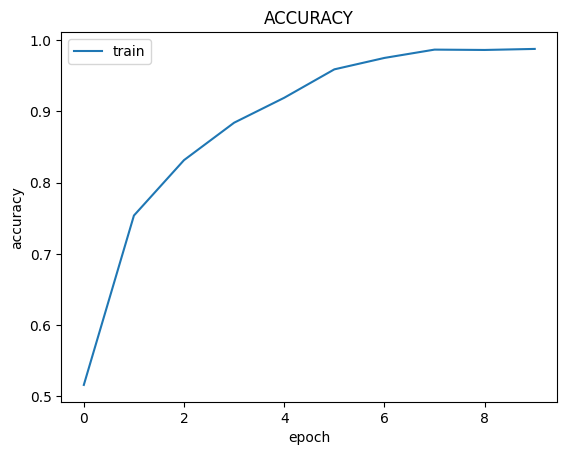

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [22]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = [np.argmax(element) for element in y_pred]
#to_categorical(y_classes, num_classes=5)
#to_categorical(test_labels, num_classes=5)
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 272s 8s/step
[2, 3, 3, 4, 3, 0, 0, 0, 0, 1]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
